<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li></ul></li><li><span><a href="#Тестирование-выбранной-модели" data-toc-modified-id="Тестирование-выбранной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование выбранной модели</a></span></li><li><span><a href="#Вывод-без-BERT" data-toc-modified-id="Вывод-без-BERT-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод без BERT</a></span></li><li><span><a href="#Вывод-с-BERT" data-toc-modified-id="Вывод-с-BERT-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод с BERT</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

# Проект для «Викишоп» без BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузим и подготовим данные.
2. Обучим разные модели. 
3. Сделаем выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
! pip install -qU evaluate

In [2]:
#! pip install -qU numpy==1.24.0

In [3]:
#! pip install -qU spacy==3.2.0

In [4]:
# Работа с массивами
import numpy as np
# Обработка и анализ данных
import pandas as pd
# Оценка времени выполнения кода
import time 
# Загрузка датафрейма
import os 
# Обработка естественного языка (NLP – Natural Language Processing)
import spacy
# Работа с регулярными выражениями
import re 
# Индикатор выполнения процессов
from tqdm.notebook import tqdm

# NLTK
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer

# BERT
import torch
import transformers
from transformers import (AutoTokenizer, DataCollatorWithPadding,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)
import evaluate

# Импорт элементов библиотеки Scikit-Learn
from sklearn.metrics import classification_report, confusion_matrix
# Классификатор случайного леса
from sklearn.ensemble import RandomForestClassifier
# Работа с датафреймом
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# TfidfVectorizer — преобразует текст в векторы объектов
# TfidfTransformer — тип модели для построения трансформатора TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
# Автоматизация раздельного декодирования признаков
from sklearn.compose import(ColumnTransformer)
# Функция для поддержки экспериментальной функции HavingGridSearchSV
from sklearn.experimental import enable_halving_search_cv
# Ускоренная автоматизация поиска лучших моделей и их параметров
from sklearn.model_selection import HalvingGridSearchCV
# Модель логистической регрессии
from sklearn.linear_model import LogisticRegression
# Улучшенный классификатор для не сбалансированных классов
from sklearn.naive_bayes import ComplementNB 
# Предобработка данных
from sklearn.preprocessing import(
    StandardScaler # стандартизация
)
# Объедининяет несколько этапов обработки данных и моделирования в один последовательный процесс
from sklearn.pipeline import Pipeline

# CatBoost (Яндекс). Классификация
from catboost import CatBoostClassifier 

# Метрика F1 - среднегармоническое между precision_score и recall_score
from sklearn.metrics import f1_score 

# Визуализация графиков
import seaborn as sns
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
from pandas.plotting import scatter_matrix

# Игнорирование всех предупреждений
from warnings import simplefilter

# Стоп слова
from nltk.corpus import stopwords as nltk_stopwords

from datasets import Dataset, Features, ClassLabel

In [5]:
spacy.prefer_gpu()

False

In [6]:
# Инизиализируем параллельное выполнение операций в Pandas 
#pandarallel.initialize(progress_bar=True)

# Снимем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# Снимем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# Игнорируем предупреждения
pd.set_option('chained_assignment', None)

# Игнорировать все предупреждения
simplefilter(action='ignore', category=FutureWarning)

In [7]:
# Загрузим данные
try:
    df = pd.read_csv('toxic_comments.csv', index_col=[0])
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])

In [8]:
data = df

In [9]:
SEED = 12345

In [10]:
print(df.shape)

(159292, 2)


In [11]:
print(df.head(3))
print()
print('Информация датасета:')
print(df.info())
print()
print('Описание датасета:')
print(df.describe())
print()
print(f'Количествово пропусков:{df.isna().sum()}') 
print()
print(f'Количествово дубликатов:{df.duplicated().sum()}')
print()
print('Уникальные значения датасета:')
print(df.nunique())

                                                                                                                                                                                                                                                                        text  \
0  Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27   
1                                                                                                                                                           D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)   
2                                  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits inste

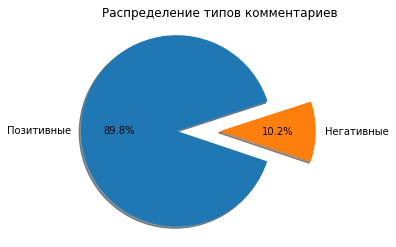

In [12]:
# распределение токсичности комментариев
plt.pie(df['toxic'].value_counts(),
        labels=['Позитивные', 'Негативные'],
        autopct='%1.1f%%',
        startangle=18,
        explode=(0.5, 0),
        shadow=True,
        radius=1.10)
plt.title('Распределение типов комментариев');

Лемматизация комментариев. Отключение лишних операций и использование spacy ускоряет процесс лемматизации.

In [13]:
sp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

<div> 

Еще один способ ускорить лемматизацию - использовать spaCy pipeline (https://spacy.io/usage/processing-pipelines)
    
    
    lemm_texts = []
    total = data.shape[0]
    nlp_pipe = nlp.pipe(data['text'].values, disable = ['ner', 'parser'])
    
    for doc in tqdm(nlp_pipe, total=total):
        lemm_text = " ".join([token.lemma_ for token in doc])    
        lemm_texts.append(lemm_text) 
    
</div>

In [14]:
# Напишем функцию для очистки текстов от лишних символов
def clear_text(text): 
    temp_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    temp_text = " ".join(temp_text.split())    
    return temp_text

# Напишем функцию для лемматизации текста
def lemmatize(text):
    doc = sp(text) 
    lem_text = ' '.join([token.lemma_ for token in doc]).lower()
    return lem_text

In [15]:
# Удалим из датасета возможные значения NaN
df = df.dropna()

Подготовка признаков

In [16]:
features = df['text']
target = df['toxic']

In [17]:
# Разделим данные
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                    test_size=0.2, random_state=SEED, stratify=target)

In [18]:
# Создадим TF-IDF векторизатор со стоп словами 
count_tf_idf = TfidfVectorizer(stop_words='english') 

In [19]:
features_train_vector = count_tf_idf.fit_transform(features_train)
features_test_vector = count_tf_idf.transform(features_test)

**Промежуточный вывод**

- В таблице 159 292 объектов.
- Дубликатов и пропусков нет.
- В таблице 2 столбца: toxic, text.
- Почти 90% твитов не токсичны.То есть в предоставленных данных имеется дисбаланс классов.
- Язык комментариев - английский.
- В строках содержатся различные спецсимволы, которые необходимо обработать.

## Обучение

Для экономии времени и ресурсов (а также по рекомендации преподавателя), проверим лишь 2 модели

### LogisticRegression

In [20]:
reg_model = LogisticRegression(class_weight='balanced', max_iter=220, random_state=SEED, verbose=1)
reg_param = {'C':[3.9, 7.7, 9.8]}

In [21]:
# Переберем параметры
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=1)),
    ('model', reg_model)])
grid_reg = GridSearchCV(reg_model, param_grid=reg_param, scoring='f1', cv=4, n_jobs=-1)

In [22]:
# Обучим модель
grid_reg.fit(features_train_vector, target_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62468D+04    |proj g|=  1.06109D+03


 This problem is unconstrained.



At iterate   50    f=  1.44245D+04    |proj g|=  8.58146D+00

At iterate  100    f=  1.43224D+04    |proj g|=  8.42398D+00

At iterate  150    f=  1.43208D+04    |proj g|=  1.08097D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    185    226      1     0     0   2.291D-01   1.432D+04
  F =   14320.702617342424     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62475D+04    |proj g|=  1.03419D+03


 This problem is unconstrained.



At iterate   50    f=  1.42376D+04    |proj g|=  3.96450D+01

At iterate  100    f=  1.42005D+04    |proj g|=  5.41886D-01

At iterate  150    f=  1.42001D+04    |proj g|=  5.50821D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    181    219      1     0     0   1.247D-02   1.420D+04
  F =   14200.074332918219     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62475D+04    |proj g|=  1.05206D+03


 This problem is unconstrained.



At iterate   50    f=  1.42589D+04    |proj g|=  1.44561D+01

At iterate  100    f=  1.41076D+04    |proj g|=  2.46040D+01

At iterate  150    f=  1.40935D+04    |proj g|=  4.57407D+00

At iterate  200    f=  1.40929D+04    |proj g|=  2.70977D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    220    258      1     0     0   9.119D-01   1.409D+04
  F =   14092.864779728163     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62475D+04    |proj g|=  1.06605D+03

At iterate   50    f=  1.42815D+04    |proj g|=  3.30581D+01

At iterate  100    f=  1.41726D+04    |proj g|=  7.01517D+00

At iterate  150    f=  1.41720D+04    |proj g|=  1.33537D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    175    209      1     0     0   7.532D-01   1.417D+04
  F =   14172.018439176129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62468D+04    |proj g|=  1.06109D+03

At iterate   50    f=  1.15464D+04    |proj g|=  6.33426D+01

At iterate  100    f=  1.11413D+04    |proj g|=  1.24222D+01

At iterate  150    f=  1.11328D+04    |proj g|=  1.24476D+01

At iterate  200    f=  1.11320D+04    |proj g|=  1.37699D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    212    244      1     0     0   5.405D-01   1.113D+04
  F =   11131.992788803655     

CONVERG

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62475D+04    |proj g|=  1.03419D+03


 This problem is unconstrained.



At iterate   50    f=  1.19286D+04    |proj g|=  3.72944D+01

At iterate  100    f=  1.10361D+04    |proj g|=  9.63440D-01

At iterate  150    f=  1.10324D+04    |proj g|=  6.15059D-01

At iterate  200    f=  1.10323D+04    |proj g|=  2.22768D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    220    260      1     0     0   1.929D-01   1.103D+04
  F =   11032.247533834052     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62475D+04    |proj g|=  1.05206D+03

At iterate   50    f=  1.12022D+04    |proj g|=  5.56151D+01

At iterate  100    f=  1.09442D+04    |proj g|=  2.49781D+01

At iterate  150    f=  1.09309D+04    |proj g|=  9.29745D-01

At iterate  200    f=  1.09295D+04    |proj g|=  8.89473D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    220    261      1     0     0   1.292D+00   1.093D+04
  F =   10929.445146594124     

STOP: T

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62475D+04    |proj g|=  1.06605D+03


 This problem is unconstrained.



At iterate   50    f=  1.15709D+04    |proj g|=  4.35832D+01

At iterate  100    f=  1.10369D+04    |proj g|=  6.30489D+01

At iterate  150    f=  1.10049D+04    |proj g|=  1.03891D+00

At iterate  200    f=  1.10015D+04    |proj g|=  1.54684D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    220    263      1     0     0   8.067D-02   1.100D+04
  F =   11001.470209455725     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62468D+04    |proj g|=  1.06109D+03


 This problem is unconstrained.



At iterate   50    f=  1.07681D+04    |proj g|=  3.56830D+02

At iterate  100    f=  1.01633D+04    |proj g|=  3.03850D+01

At iterate  150    f=  1.01368D+04    |proj g|=  1.14076D+01

At iterate  200    f=  1.01353D+04    |proj g|=  2.32729D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    220    254      1     0     0   2.143D+00   1.014D+04
  F =   10135.210480927219     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62475D+04    |proj g|=  1.03419D+03

At iterate   50    f=  1.07778D+04    |proj g|=  1.02271D+01

At iterate  100    f=  1.00711D+04    |proj g|=  3.06302D+01

At iterate  150    f=  1.00450D+04    |proj g|=  7.01277D+00

At iterate  200    f=  1.00429D+04    |proj g|=  1.73641D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    220    255      1     0     0   2.326D+00   1.004D+04
  F =   10042.739095888524     

STOP: T

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62475D+04    |proj g|=  1.05206D+03


 This problem is unconstrained.



At iterate   50    f=  1.02699D+04    |proj g|=  9.02392D+01

At iterate  100    f=  9.95003D+03    |proj g|=  1.38342D+01

At iterate  150    f=  9.94305D+03    |proj g|=  5.93218D+00

At iterate  200    f=  9.94223D+03    |proj g|=  7.67696D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    220    258      1     0     0   1.425D+00   9.942D+03
  F =   9942.2074752366170     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62475D+04    |proj g|=  1.06605D+03


 This problem is unconstrained.



At iterate   50    f=  1.01985D+04    |proj g|=  1.10279D+02

At iterate  100    f=  1.00256D+04    |proj g|=  4.81593D+01

At iterate  150    f=  1.00111D+04    |proj g|=  5.17751D+00

At iterate  200    f=  1.00098D+04    |proj g|=  4.19323D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    220    259      1     0     0   4.159D-01   1.001D+04
  F =   10009.629034711863     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       165480     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.83298D+04    |proj g|=  1.40446D+03


 This problem is unconstrained.



At iterate   50    f=  1.50294D+04    |proj g|=  4.89632D+01

At iterate  100    f=  1.46614D+04    |proj g|=  4.87124D+01

At iterate  150    f=  1.46438D+04    |proj g|=  5.69567D+00

At iterate  200    f=  1.46422D+04    |proj g|=  9.15526D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    220    263      1     0     0   5.388D-01   1.464D+04
  F =   14642.137234631560     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min finished


GridSearchCV(cv=4,
             estimator=LogisticRegression(class_weight='balanced', max_iter=220,
                                          random_state=12345, verbose=1),
             n_jobs=-1, param_grid={'C': [3.9, 7.7, 9.8]}, scoring='f1')

In [23]:
grid_reg.best_score_

0.7681116861757981

In [24]:
grid_reg.best_params_

{'C': 7.7}

### RandomForestClassifier

In [25]:
forest_model = RandomForestClassifier(random_state=SEED, class_weight='balanced', verbose=1)
forest_param = {'max_depth':[10, 15, 20],
                'n_estimators':[100, 200, 300],
                'max_features': [3, 5, 8]}

In [26]:
# Переберем параметры
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=1)),
    ('model', forest_model)])
grid_forest = GridSearchCV(forest_model, param_grid=forest_param, scoring='f1', cv=4, n_jobs=-1)

In [27]:
# Обучим модель
grid_forest.fit(features_train_vector, target_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20], 'max_features': [3, 5, 8],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [28]:
grid_forest.best_score_

0.30304318597356483

In [29]:
grid_forest.best_params_

{'max_depth': 20, 'max_features': 8, 'n_estimators': 300}

## Тестирование выбранной модели

In [30]:
test_predict = grid_reg.predict(features_test_vector)

In [31]:
# Зададим пороговое значения, которое предъявил заказчик:
test_f1 = f1_score(target_test, test_predict)

if test_f1 <= 0.75:
    print(f'Значение f1 = {test_f1} не удовлетворяет требования заказчика!')
else:
    print(f'Значение f1 = {test_f1} удовлетворяет требования заказчика!')

Значение f1 = 0.7780996523754344 удовлетворяет требования заказчика!


## Вывод без BERT

В ходе тестирования модель Логистическая регрессия показала значение метрики f1 = 0.7780996523754344, что выше порогового значения, обозначенного заказчиками.

Линейная модель обучается в разы быстрее Случайного дерева и имеет лучшие результаты.

# Проект для «Викишоп» c BERT

In [32]:
# Подготовим к использованию данные обработки естественного языка
TOKENIZER = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [33]:
# Делаем выборки одинаковой длины
DATA_COLLATOR = DataCollatorWithPadding(tokenizer=TOKENIZER)

In [34]:
# Добавляем оценщик
F1 = evaluate.load("f1")

In [35]:
def preprocess(examples):
    return TOKENIZER(examples["text"], truncation=True)

In [36]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return F1.compute(predictions=predictions, references=labels)

In [37]:
# Преобразуем наши данные
data['text'] = data['text'].apply(clear_text)
data.head()

,text,toxic
0,Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalisms just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now,0
1,D aww He matches this background colour I m seemingly stuck with Thanks talk January UTC,0
2,Hey man I m really not trying to edit war It s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info,0
3,More I can t make any real suggestions on improvement I wondered if the section statistics should be later on or a subsection of types of accidents I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up It s listed in the relevant form eg Wikipedia Good article nominations Transport,0
4,You sir are my hero Any chance you remember what page that s on,0


In [38]:
# Разделим данные
train, test = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data['toxic'])
train = Dataset.from_pandas(train.rename({'toxic': 'labels'},
                                         axis=1)).class_encode_column("labels")
test = Dataset.from_pandas(test.rename({'toxic': 'labels'},
                                       axis=1)).class_encode_column("labels")

Stringifying the column:   0%|          | 0/127433 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/127433 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/31859 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/31859 [00:00<?, ? examples/s]

In [39]:
%%time

tokenized_train = train.map(preprocess, batched=True)
tokenized_test = test.map(preprocess, batched=True)

Map:   0%|          | 0/127433 [00:00<?, ? examples/s]

Map:   0%|          | 0/31859 [00:00<?, ? examples/s]

CPU times: user 40 s, sys: 363 ms, total: 40.3 s
Wall time: 41 s


In [40]:
# Создадим метки 
id2label = {0: "NON-TOXIC", 1: "TOXIC"}
label2id = {"NON-TOXIC": 0, "TOXIC": 1}

In [41]:
# Зададим модель
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label,
    label2id=label2id).to("cuda")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# Введем параметры для обучения модели
training_args = TrainingArguments(output_dir="my_model",
                                  learning_rate=3e-5,
                                  per_device_train_batch_size=10,
                                  per_device_eval_batch_size=10,
                                  num_train_epochs=5,
                                  evaluation_strategy="no",
                                  save_strategy="no")

In [ ]:
# Обучим модель
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train, 
    tokenizer=TOKENIZER,
    data_collator=DATA_COLLATOR,
)

trainer.train()

In [ ]:
# Посмотрим какие будут предсказания
predictions = trainer.predict(tokenized_test)
predicted_labels = (predictions.predictions[:, 1] > 0).astype(int)

In [ ]:
# Выведем полученные данные
# Отобразим текстовый отчет по основным показателям классификации
print(classification_report(tokenized_test['labels'], predicted_labels))
# Оценим точность классификации
sns.heatmap(confusion_matrix(tokenized_test['labels'], predicted_labels, normalize='true'),
            annot=True, fmt='0.2%')
plt.show()

## Вывод с BERT

Таким образом разработан инструмент проверки комментариев на токсичность с BERT. Проект с BERT выполнялся локально из-за ограниченных ресурсов платформы.
На отложенной тестовой выборке модель показала значение метрики F1 = 0.83, что выше порога 0.75.

## Итоговый вывод


В результате выполнения проекта решена задача и достигнута цель -  найдена модель, которая удовлетворяет требованиям заказчика: 

**Для проекта без BERT это:**

Логистическая регрессия с параметрами: {'C': 7.7, class_weight='balanced'}
f1 = 0.7780996523754344

**Для проекта с BERT:**
F1 = 0.83

Итого, BERT в нашем случае показал большее качество. Однако для проекта с BERT нужны вычислительные мощности и считается всё очень долго. Поэтому выбирать заказчику - если нужен быстрый результат, то выбираем проект без BERT, иначе с BERT.

В ходе проекта было выполнено и выявлено:
- В таблице 159 292 объектов.
- Дубликатов и пропусков нет.
- В таблице 2 столбца: toxic, text.
- Почти 90% твитов не токсичны. То есть в предоставленных данных имеется дисбаланс классов.
- Язык комментариев - английский.
- В строках содержатся различные спецсимволы, которые необходимо обработать.
- Выбран способ баланса классов, сформированы выборки.
- Обучены модели и выбрана лучшая из них.
- Выведены параметры качества модели.
- Предложено 2 варианта проекта - с BERT и без него

Значение метрики F1 достигло необходимого значения только у модели LogisticRegression. Модель Random Forest Classifier не справилась с поставленной задачей.
Из-за большого количества наблюдений и их сложной структуры мощности обычного компьютера периодически не хватает для полноценного анализа, из-за этого время обучения и работы возрастает, и не все модели можно детально рассмотреть.